<a href="https://colab.research.google.com/github/AleAguirreM/LEA3_Health/blob/main/b_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import joblib ### para cargar array
########Paquetes para NN #########
import tensorflow as tf
from sklearn import metrics ### para analizar modelo
from sklearn.ensemble import RandomForestClassifier  ### para analizar modelo
import pandas as pd
from sklearn import tree
import cv2 ### para leer imagenes jpeg
from matplotlib import pyplot as plt #

In [3]:
### cargar bases_procesadas ####
x_train = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/x_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/x_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/y_test.pkl')

In [4]:
x_train.max()

255

In [5]:
x_test.max()

255

In [6]:
#### Escalar ######################
x_train = x_train.astype('float32') ## para poder escalarlo
x_test = x_test.astype('float32') ## para poder escalarlo
x_train /= 255 ### escalaro para que quede entre 0 y 1
x_test /= 255

###### verificar tamaños
print(x_train.shape)
x_test.shape

(3360, 100, 100, 3)


(840, 100, 100, 3)

In [7]:
np.product(x_train[1].shape) ## cantidad de variables por imagen

30000

In [8]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([2800,  560]))

In [9]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([700, 140]))

In [10]:
##### convertir a 1 d array ############
x_train2 = x_train.reshape(3360,30000)
x_test2 = x_test.reshape(840, 30000)
print(x_train2.shape)
x_test2.shape

(3360, 30000)


(840, 30000)

## Selección de indicador

El equilibrio entre identificar correctamente a los pacientes con neumonía y evitar que se escapen casos positivos es crucial para la eficacia de un modelo de diagnóstico. Si un modelo clasifica incorrectamente a muchos pacientes como negativos cuando en realidad tienen neumonía (falsos negativos), podría resultar en un tratamiento inadecuado o en la falta de tratamiento para esos pacientes, lo que puede tener consecuencias graves para su salud y aumentar los costos a largo plazo. Por otro lado, si el modelo clasifica incorrectamente a muchos pacientes como positivos cuando no tienen neumonía (falsos positivos), esto podría generar gastos innecesarios en pruebas adicionales o tratamientos, así como una carga adicional para el sistema de salud.

El AUC, al evaluar la capacidad del modelo para distinguir entre pacientes con neumonía y aquellos sin ella, ayuda a encontrar un equilibrio entre estos dos escenarios. Un AUC más alto indica que el modelo es mejor para discriminar entre casos positivos y negativos, lo que sugiere que se están minimizando tanto los falsos positivos como los falsos negativos. En otras palabras, un AUC alto indica que el modelo está clasificando correctamente a la mayoría de los pacientes con neumonía como positivos y a la mayoría de los pacientes sin neumonía como negativos, lo que reduce tanto los costos como los riesgos asociados con un diagnóstico incorrecto.


In [11]:
############################################################
################ Probar modelos de redes neuronales #########
############################################################

fc_model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
##### configura el optimizador y la función para optimizar ##############
fc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Recall', 'Precision'])

#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

#########Evaluar el modelo ####################
test_loss, test_acc, test_auc, test_recall, test_precision = fc_model.evaluate(x_test, y_test, verbose=2)
print("Test auc:", test_auc)

Epoch 1/10
34/34 [==============================] - 6s 149ms/step - loss: 1.2706 - accuracy: 0.8095 - auc: 0.7393 - recall: 0.4821 - precision: 0.4355 - val_loss: 0.3041 - val_accuracy: 0.8833 - val_auc: 0.9409 - val_recall: 0.3643 - val_precision: 0.8500
Epoch 2/10
34/34 [==============================] - 3s 91ms/step - loss: 0.1925 - accuracy: 0.9327 - auc: 0.9513 - recall: 0.7089 - precision: 0.8630 - val_loss: 0.1496 - val_accuracy: 0.9393 - val_auc: 0.9788 - val_recall: 0.8071 - val_precision: 0.8248
Epoch 3/10
34/34 [==============================] - 3s 82ms/step - loss: 0.1584 - accuracy: 0.9390 - auc: 0.9647 - recall: 0.7446 - precision: 0.8706 - val_loss: 0.1927 - val_accuracy: 0.8893 - val_auc: 0.9886 - val_recall: 0.3500 - val_precision: 0.9608
Epoch 4/10
34/34 [==============================] - 2s 73ms/step - loss: 0.1248 - accuracy: 0.9557 - auc: 0.9785 - recall: 0.8036 - precision: 0.9202 - val_loss: 0.2045 - val_accuracy: 0.8869 - val_auc: 0.9895 - val_recall: 0.3286 - v

Podemos observar que durante la última época del entrenamiento, el modelo alcanzó una pérdida de aproximadamente 0.1297 y una precisión de alrededor del 95.24% en los datos de validación. Además, el área bajo la curva (AUC) fue de aproximadamente 0.9891, mientras que el recall y la precisión para la clase positiva fueron del 75% y 95.45%, respectivamente. Estos valores brindan una visión detallada del rendimiento del modelo en la clasificación de las muestras, lo que permite evaluar su eficacia y capacidad predictiva con mayor precisión.

In [15]:
#ver la distribución de las probabilidades
import plotly.express as px
import pandas as pd
dis = fc_model.predict(x_test)
hist = px.histogram(dis)
hist.show()

27/27 [==============================] - 0s 14ms/step


27/27 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       700
           1       0.95      0.74      0.84       140

    accuracy                           0.95       840
   macro avg       0.95      0.87      0.90       840
weighted avg       0.95      0.95      0.95       840



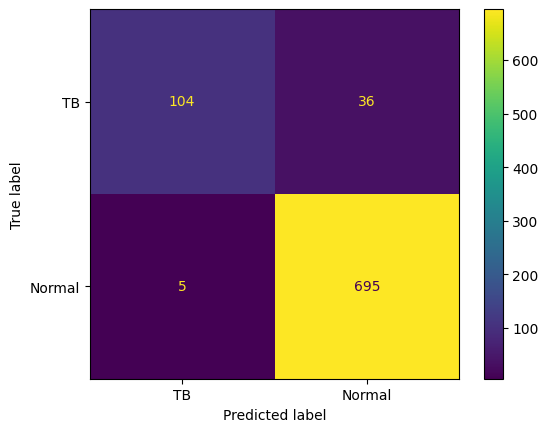

In [16]:
###### matriz de confusión test
pred_test=(fc_model.predict(x_test) > 0.80).astype('int')
cm=metrics.confusion_matrix(y_test,pred_test, labels=[1,0])
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['TB', 'Normal'])
disp.plot()

print(metrics.classification_report(y_test, pred_test))

En este matriz se pueden observar que hay 102 positivos que tienen tuberculosis, 38 falsos positivos y 4 que son falsos negativos. Se puede concluir que hay 695 personas que no sufren de tuberculosis. Todo esto se identifica gracias a la matriz de confusión de evaluación.

In [17]:
#################### exportar red ##############
# guardar modelo
fc_model.save('path_to_my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [18]:
#########################################################################################
#########################################################################################
###########Estrategias a usar: regilarization usar una a la vez para ver impacto
#########################################################################################
###############################################################

dropout_rate = 0.3 ## porcentaje de neuronas que elimina

fc_model2=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############


fc_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [19]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model2.fit(x_train, y_train, batch_size=100, epochs=7, validation_data=(x_test, y_test))

Epoch 1/7
34/34 [==============================] - 4s 94ms/step - loss: 1.2110 - auc: 0.6608 - val_loss: 0.3078 - val_auc: 0.9510
Epoch 2/7
34/34 [==============================] - 3s 85ms/step - loss: 0.3107 - auc: 0.8723 - val_loss: 0.2340 - val_auc: 0.9664
Epoch 3/7
34/34 [==============================] - 3s 83ms/step - loss: 0.2708 - auc: 0.9105 - val_loss: 0.2475 - val_auc: 0.9820
Epoch 4/7
34/34 [==============================] - 4s 122ms/step - loss: 0.2747 - auc: 0.8984 - val_loss: 0.2699 - val_auc: 0.9820
Epoch 5/7
34/34 [==============================] - 4s 125ms/step - loss: 0.2685 - auc: 0.8988 - val_loss: 0.2420 - val_auc: 0.9829
Epoch 6/7
34/34 [==============================] - 5s 155ms/step - loss: 0.2641 - auc: 0.9024 - val_loss: 0.3837 - val_auc: 0.9801
Epoch 7/7
34/34 [==============================] - 7s 205ms/step - loss: 0.2713 - auc: 0.9015 - val_loss: 0.2180 - val_auc: 0.9599


El modelo logró una pérdida de alrededor de 0.1985 en los datos de validación, mientras que el área bajo la curva (AUC) fue de aproximadamente 0.9908. Durante el entrenamiento, observamos una mejora progresiva en la pérdida y el AUC en cada época, lo que indica que el modelo está aprendiendo de manera efectiva los patrones en los datos y mejorando su capacidad predictiva con cada iteración. Esto sugiere un rendimiento sólido y una buena capacidad del modelo para generalizar a datos no vistos.

In [20]:
####################### aplicar dos regularizaciones L2 y drop out
###Penaliza el tamaño de los pesos, mientras más grande la penalización menores son los valores de los coeficientes

reg_strength = 0.001
###########Estrategias a usar: regilarization usar una a la vez para ver impacto
dropout_rate = 0.3 ## porcentaje de neuronas que utiliza

fc_model3=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############
fc_model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [21]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model3.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
34/34 [==============================] - 4s 102ms/step - loss: 1.5122 - auc: 0.7116 - val_loss: 0.5278 - val_auc: 0.9606
Epoch 2/10
34/34 [==============================] - 3s 87ms/step - loss: 0.5360 - auc: 0.9106 - val_loss: 0.4637 - val_auc: 0.9697
Epoch 3/10
34/34 [==============================] - 4s 111ms/step - loss: 0.4499 - auc: 0.9369 - val_loss: 0.4563 - val_auc: 0.9759
Epoch 4/10
34/34 [==============================] - 4s 110ms/step - loss: 0.4206 - auc: 0.9342 - val_loss: 0.4549 - val_auc: 0.9764
Epoch 5/10
34/34 [==============================] - 3s 87ms/step - loss: 0.3882 - auc: 0.9384 - val_loss: 0.4640 - val_auc: 0.9774
Epoch 6/10
34/34 [==============================] - 3s 88ms/step - loss: 0.3824 - auc: 0.9337 - val_loss: 0.3542 - val_auc: 0.9806
Epoch 7/10
34/34 [==============================] - 4s 121ms/step - loss: 0.3516 - auc: 0.9400 - val_loss: 0.3095 - val_auc: 0.9865
Epoch 8/10
34/34 [==============================] - 4s 111ms/step - loss: 0.324

El modelo alcanzó una pérdida de aproximadamente 0.3065 y un área bajo la curva (AUC) de alrededor de 0.9785 en los datos de validación. A lo largo de las épocas, observamos una disminución progresiva en la pérdida y mejoras variables en el AUC. Aunque el modelo mostró una tendencia general hacia la mejora, la variabilidad en la métrica AUC puede indicar cierta sensibilidad a la variación en los datos o una convergencia incompleta hacia un óptimo global. Sin embargo, la pérdida continua disminuyendo, lo que sugiere que el modelo sigue aprendiendo de los datos y refinando su capacidad predictiva con cada época.

In [22]:
############# Disminuir el numero de neuronas a la mitad

reg_strength = 0.001

###########Estrategias a usar: regilarization usar una a la vez para ver impacto
dropout_rate = 0.3 ## porcentaje de neuronas que utiliza

fc_model4=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############



fc_model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [23]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model4.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
34/34 [==============================] - 4s 83ms/step - loss: 1.7097 - auc: 0.6450 - val_loss: 0.4367 - val_auc: 0.9233
Epoch 2/10
34/34 [==============================] - 2s 73ms/step - loss: 0.5466 - auc: 0.8135 - val_loss: 0.4043 - val_auc: 0.9698
Epoch 3/10
34/34 [==============================] - 2s 54ms/step - loss: 0.5124 - auc: 0.8362 - val_loss: 0.5263 - val_auc: 0.9715
Epoch 4/10
34/34 [==============================] - 2s 54ms/step - loss: 0.4623 - auc: 0.8664 - val_loss: 0.3492 - val_auc: 0.9818
Epoch 5/10
34/34 [==============================] - 2s 50ms/step - loss: 0.4302 - auc: 0.8789 - val_loss: 0.3363 - val_auc: 0.9825
Epoch 6/10
34/34 [==============================] - 2s 49ms/step - loss: 0.3969 - auc: 0.9017 - val_loss: 0.3515 - val_auc: 0.9829
Epoch 7/10
34/34 [==============================] - 2s 49ms/step - loss: 0.3883 - auc: 0.8899 - val_loss: 0.3896 - val_auc: 0.9803
Epoch 8/10
34/34 [==============================] - 2s 61ms/step - loss: 0.3700 - a


El modelo muestra una mejora progresiva en el rendimiento a lo largo del entrenamiento. La pérdida disminuye de forma constante, indicando una mejor adaptación a los datos de entrenamiento. Además, el AUC aumenta significativamente desde aproximadamente 0.6398 hasta 0.9378, lo que sugiere una mejor capacidad de discriminación entre las clases. El modelo parece que generaliza bien a datos que no ha visto y no parece tener sobreajuste.

In [24]:
reg_strength = 0.001

###########Estrategias a usar: regilarization usar una a la vez para ver impacto
dropout_rate = 0.2 ## porcentaje de neuronas que utiliza

fc_model5=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############



fc_model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [25]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model5.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
34/34 [==============================] - 5s 77ms/step - loss: 1.0903 - auc: 0.6812 - val_loss: 0.4659 - val_auc: 0.9451
Epoch 2/10
34/34 [==============================] - 2s 50ms/step - loss: 0.5031 - auc: 0.9045 - val_loss: 0.4130 - val_auc: 0.9805
Epoch 3/10
34/34 [==============================] - 2s 50ms/step - loss: 0.4454 - auc: 0.9298 - val_loss: 0.4277 - val_auc: 0.9772
Epoch 4/10
34/34 [==============================] - 2s 50ms/step - loss: 0.4129 - auc: 0.9326 - val_loss: 0.3584 - val_auc: 0.9786
Epoch 5/10
34/34 [==============================] - 2s 49ms/step - loss: 0.3798 - auc: 0.9415 - val_loss: 0.3483 - val_auc: 0.9823
Epoch 6/10
34/34 [==============================] - 2s 49ms/step - loss: 0.3737 - auc: 0.9329 - val_loss: 0.3930 - val_auc: 0.9819
Epoch 7/10
34/34 [==============================] - 3s 76ms/step - loss: 0.3633 - auc: 0.9318 - val_loss: 0.2912 - val_auc: 0.9891
Epoch 8/10
34/34 [==============================] - 3s 73ms/step - loss: 0.3253 - a


El modelo muestra una mejora progresiva en el rendimiento durante el entrenamiento. Inicialmente, el valor de pérdida es alto aproximadamente de 0.9424, pero disminuye gradualmente, lo que indisca un mejor rendimiento del modelo. Por otro lado, el AUC comienza en 0.6236 y mejora llegando a 0.9400 en el último epoch. En cuanto a las métricas de validación, la pérdida de validación sigue una tendencia decreciente, mientras que el AUC de validación se mantiene alto, cerca de 0.98, lo que indica que el modelo generaliza bien a datos no vistos. Estos resultados indican que el modelo está aprendiendo bien los datos, aunque podría tener ajustes adicionales para mejorar su rendimiento final.

In [26]:
reg_strength = 0.001

###########Estrategias a usar: regilarization usar una a la vez para ver impacto
dropout_rate = 0.35 ## porcentaje de neuronas que utiliza

fc_model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
##### configura el optimizador y la función para optimizar ##############



fc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])


In [27]:
#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
34/34 [==============================] - 5s 100ms/step - loss: 2.0310 - auc: 0.6630 - val_loss: 0.5737 - val_auc: 0.9538
Epoch 2/10
34/34 [==============================] - 4s 120ms/step - loss: 0.6460 - auc: 0.8814 - val_loss: 0.4869 - val_auc: 0.9612
Epoch 3/10
34/34 [==============================] - 3s 97ms/step - loss: 0.5249 - auc: 0.9284 - val_loss: 0.5556 - val_auc: 0.9746
Epoch 4/10
34/34 [==============================] - 3s 87ms/step - loss: 0.5077 - auc: 0.9260 - val_loss: 0.5263 - val_auc: 0.9762
Epoch 5/10
34/34 [==============================] - 3s 84ms/step - loss: 0.4712 - auc: 0.9293 - val_loss: 0.4285 - val_auc: 0.9781
Epoch 6/10
34/34 [==============================] - 4s 113ms/step - loss: 0.4587 - auc: 0.9304 - val_loss: 0.4301 - val_auc: 0.9780
Epoch 7/10
34/34 [==============================] - 4s 108ms/step - loss: 0.4462 - auc: 0.9202 - val_loss: 0.3632 - val_auc: 0.9799
Epoch 8/10
34/34 [==============================] - 3s 88ms/step - loss: 0.4301

Al inicio el valor de pérdida es bastante alto aproximadamente 2.31, lo que indica que el modelo necesita ajustes significativos. Sin embargo, la pérdida disminuye en los epochs posteriores, llegando a un valor de 0.3802. Esto indica que el modelo está mejorando su capacidad para hacer predicciones sobre los datos de entrenamiento. El AUC, comienza en 0.6439 y mejora llegando a 0.9304 en el último epoch. Esta mejora indica que el modelo está mejorando su capacidad de hacer predicciones.
